In [1]:
import torch
from tile_types import TileType
from world import World
from agent import Agent
from rstdp import RSTDPNetwork
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc

# Usage example
input_size = 9*len(TileType)
hidden_size = 20
output_size = 5
lr = 0.1
num_epochs = 200
num_steps_per_epoch = 1000
num_ticks_per_step = 50
reward = 0
action = 0
p_random_action_initial = 0.2
p_random_action_decay = 0.99

agent = Agent()
model = RSTDPNetwork(input_size, hidden_size, output_size, lr)
duration_history = []
world = World()

def simulate_epoch() -> int:
    step: int = 0
    reward: float = 0.0
    p_random_action: float = p_random_action_initial
    for step in range(num_steps_per_epoch):
        # Decay the learning parameters
        p_random_action *= p_random_action_decay
        
        # Generate the visual input
        agent.update_visual_field(world)
        
        # Tick as many times as required to collect enough spikes
        for tick in range(num_ticks_per_step):
            # Compute the input spikes
            input_spikes = torch.rand(input_size).gt(agent.visual_field.flatten() * 0.5)
            model.forward(input_spikes, reward)

        # Compute action and reward
        action: int = torch.argmax(model.snn.hidden_layer.spike_count).item() # type: ignore
        if torch.rand(1) < p_random_action:
            action = int(torch.randint(0, len(agent.actions), size=(1,)))

        reward = agent.step(action, world)
        model.update_weights()
        
        # Exit early if the agent is done
        if world.is_complete():
            print('Eureka!')
            break
    return step

# Training loop
for _ in tqdm(range(num_epochs), desc='Epoch', leave=True):
    gc.collect()
    
    # Initialize the session 
    world.reset()
    model.reset()

    sim_duration = simulate_epoch()
        
    # Update the performance history
    duration_history.append(sim_duration)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

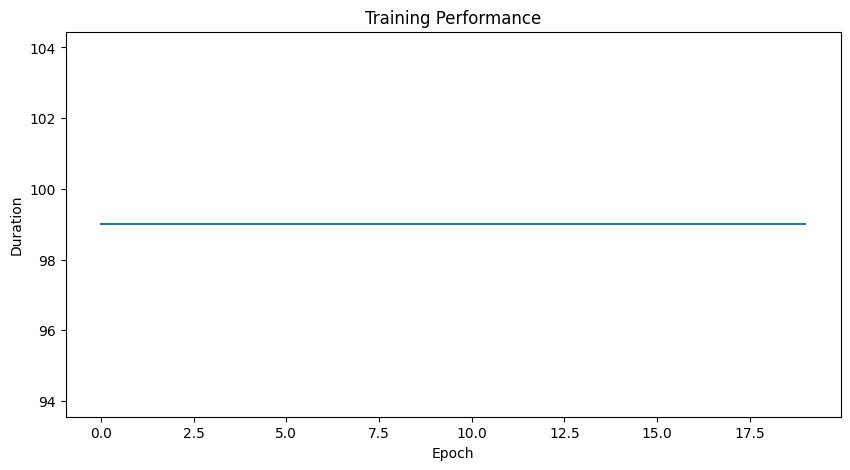

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(duration_history)
plt.ylabel('Duration')
plt.xlabel('Epoch')
plt.title('Training Performance');